In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [19]:
# global variables

look_back = 21
lead_time = 30
filename = '../../../data/Arctic_domain_mean_1979_2018 - Curated.csv'
pcmciplus_features = ['LW_down', 'snowfall', 'sst', 'sosaline', 'surface_pressure', 'sea_ice_extent']

In [20]:
# from google.colab import files
# import io

# uploaded = files.upload()
# df = pd.read_csv(io.BytesIO(uploaded[filename]))
# df = df[7305:]
# df

# Reading the dataset
df = pd.read_csv(filename)
df = df[7305:]
df.head()

,Day,wind_10m,specific_humidity,LW_down,SW_down,rainfall,snowfall,sosaline,sst,t2m,surface_pressure,sea_ice_extent
7305,1/1/1999,4.987515,0.891843,183.786092,1.120906,0.700735,0.501109,33.316996,273.467869,250.884060,985.112721,13823248
7306,1/2/1999,5.075952,0.905535,183.851814,1.193514,0.712730,0.482221,33.316996,273.453826,250.359328,984.092282,13885522
7307,1/3/1999,4.931520,0.911672,184.426913,1.263909,0.677339,0.480718,33.316996,273.454385,250.327500,982.300080,13884279
7308,1/4/1999,4.761644,0.911301,187.528326,1.269229,0.824016,0.697950,33.316996,273.459797,249.905730,983.250565,13912624
7309,1/5/1999,4.739850,0.901353,187.326709,1.552208,0.926681,0.835868,33.316996,273.463975,250.254873,984.247389,13890148


In [4]:
df['Day'] = pd.to_datetime(df['Day'], infer_datetime_format=True)
df.set_index('Day', inplace=True)
df = df.astype(float)                 # cast df to float
# df = df[pcmciplus_features]
# df.tail(len(df))

/tmp/ipykernel_3420/659794668.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Day'] = pd.to_datetime(df['Day'], infer_datetime_format=True)


In [5]:
def create_model_data (dataset, look_back, lead_time):
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-lead_time):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back + lead_time])
    return np.array(dataX), np.array(dataY)

In [6]:
target_index = df.columns.tolist().index('sea_ice_extent')

dataset = df.values.astype('float32')               # DataFrame converted to Numpy Array

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

X, y = create_model_data (dataset, look_back=look_back, lead_time=lead_time)
y = y[:,target_index]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

<function matplotlib.pyplot.show(close=None, block=None)>

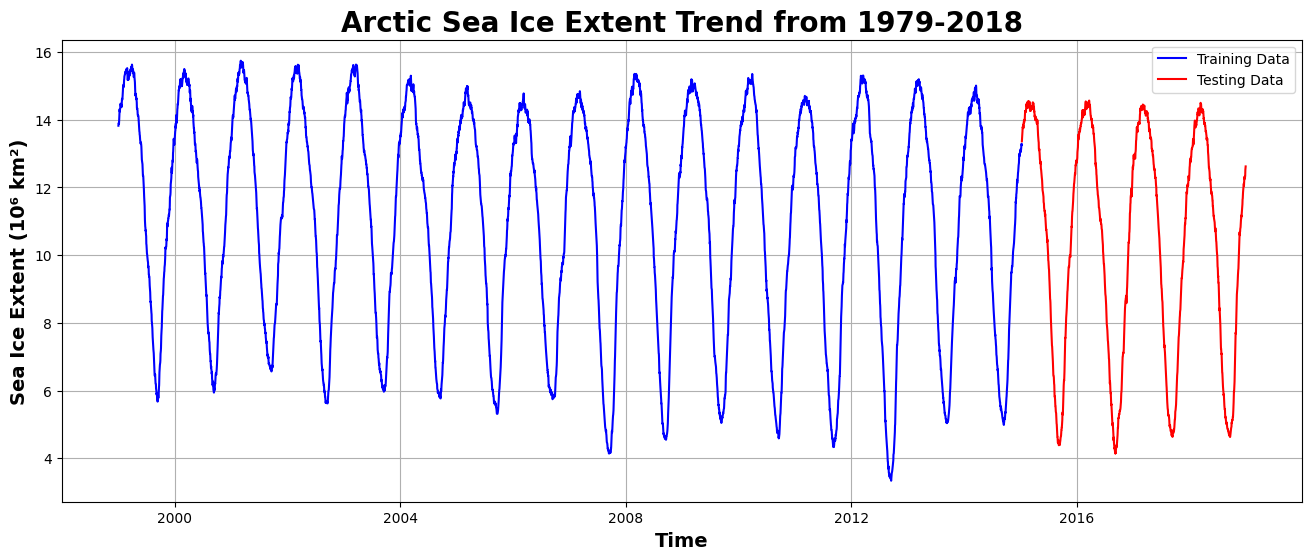

In [8]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Trend from 1979-2018', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(df['sea_ice_extent'][:len(df)-len(y_test)]/10**6, 'blue', label='Training Data')
plt.plot(df['sea_ice_extent'][len(df)-len(y_test):]/10**6, 'red', label='Testing Data')
plt.legend()
plt.grid()
plt.show

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, GRU, Dense

input_shape=(X.shape[1], X.shape[2])

model = Sequential()
model.add(GRU(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

2024-11-27 18:00:54.421233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-27 18:00:54.521408: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-27 18:00:57.169692: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 21, 64)            14784     
                                                                 
 dropout (Dropout)           (None, 21, 64)            0         
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 121,921
Trainable params: 121,921
Non-trai

In [10]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/100
82/82 [==============================] - 6s 41ms/step - loss: 0.0224 - mae: 0.0942 - mse: 0.0224 - val_loss: 0.0011 - val_mae: 0.0278 - val_mse: 0.0011
Epoch 2/100
82/82 [==============================] - 3s 32ms/step - loss: 0.0034 - mae: 0.0463 - mse: 0.0034 - val_loss: 8.7558e-04 - val_mae: 0.0247 - val_mse: 8.7558e-04
Epoch 3/100
82/82 [==============================] - 3s 32ms/step - loss: 0.0028 - mae: 0.0420 - mse: 0.0028 - val_loss: 0.0026 - val_mae: 0.0447 - val_mse: 0.0026
Epoch 4/100
82/82 [==============================] - 3s 32ms/step - loss: 0.0023 - mae: 0.0385 - mse: 0.0023 - val_loss: 8.1865e-04 - val_mae: 0.0240 - val_mse: 8.1865e-04
Epoch 5/100
82/82 [==============================] - 3s 32ms/step - loss: 0.0021 - mae: 0.0367 - mse: 0.0021 - val_loss: 0.0014 - val_mae: 0.0323 - val_mse: 0.0014
Epoch 6/100
82/82 [==============================] - 3s 31ms/step - loss: 0.0020 - mae: 0.0355 - mse: 0.0020 - val_loss: 0.0010 - val_mae: 0.0275 - val_mse: 0.0010


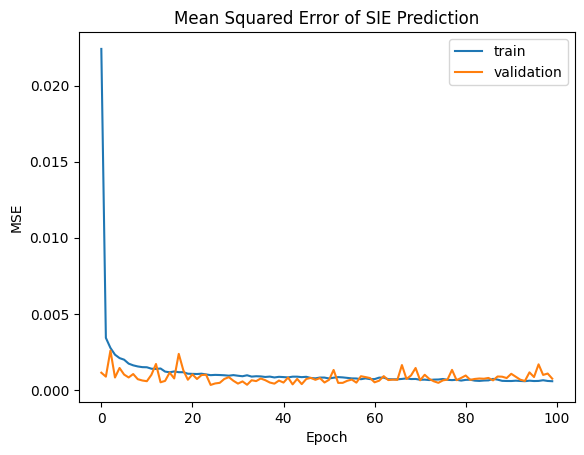

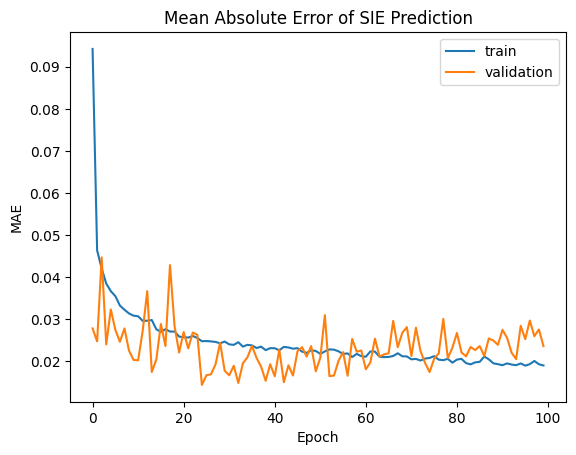

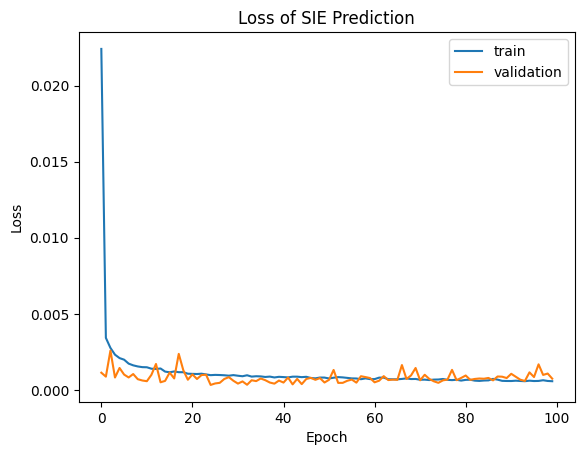

In [11]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error of SIE Prediction')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error of SIE Prediction')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of SIE Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from numpy import sqrt

#model.load_weights("weights.best.hdf5")

cols = len(df.columns)
pred = model.predict(X_test)

predicted_dataset = dataset
predicted_dataset[len(predicted_dataset)-len(pred):, cols-1] = pred[:, 0]
scaled_predicted_dataset = scaler.inverse_transform(predicted_dataset)

predicted_df = df.copy()
predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):] = scaled_predicted_dataset[len(predicted_dataset)-len(pred):, cols-1]

predictions = pd.DataFrame()
predictions['predicted'] = (predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions['actual'] = (df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions = predictions.astype(float)

46/46 [==============================] - 1s 9ms/step


In [13]:
# !pip install --upgrade seaborn

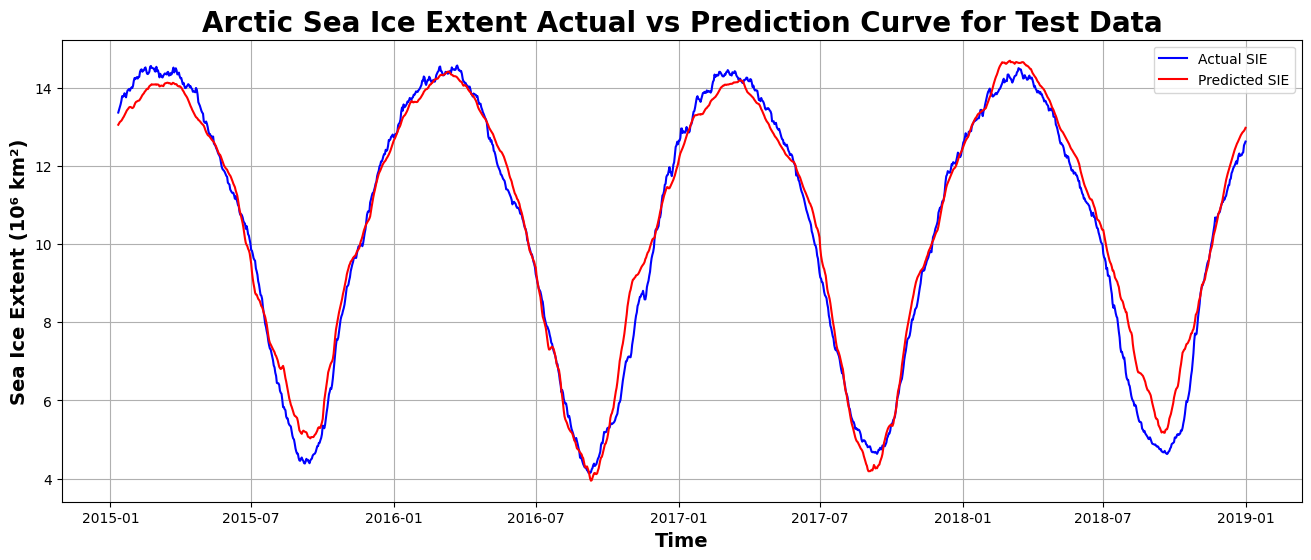

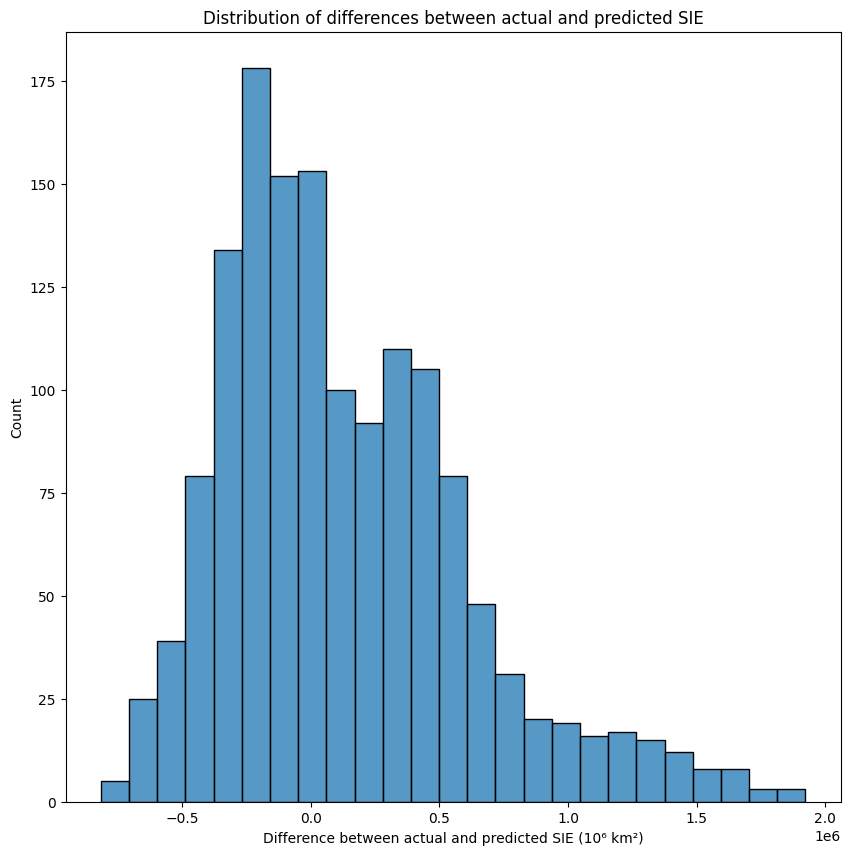

MSE :  244859297591.37466 (10⁶ km²)
MSPE : 0.5632255612875302 %
RMSE :  494832.59552233893 (10⁶ km²)
RMSPE : 7.5048355164355876 %
MAE :  371165.9593383873 (10⁶ km²)
MAPE :  4.346242547355995 %
R2 :  0.9758149404169573


In [14]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Actual vs Prediction Curve for Test Data', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(predictions['actual']/10**6, 'blue', label='Actual SIE')
plt.plot(predictions['predicted']/10**6, 'red', label='Predicted SIE')
plt.legend()
plt.grid()
plt.show

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
plt.xlabel('Difference between actual and predicted SIE (10\u2076 km\u00b2)')
sns.histplot(predictions['diff'])
plt.title('Distribution of differences between actual and predicted SIE')
plt.show()

mspe = (np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values))) * 100
rmspe = (np.sqrt(np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values)))) * 100

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MSPE :", mspe, "%")
print("RMSE : ", sqrt(mean_squared_error(predictions['predicted'].values, predictions['actual'].values)), "(10\u2076 km\u00b2)")
print("RMSPE :", rmspe, "%")
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MAPE : ", mean_absolute_percentage_error(predictions['predicted'].values, predictions['actual'].values)*100, "%")
print("R2 : ", r2_score(predictions['predicted'].values, predictions['actual'].values))

In [15]:
# while True:pass